# Dask Machine Learning

In [1]:
from dask.distributed import Client, progress

In [8]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40273 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 31.62 GB


## Scikit Learn Estimator

In [2]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [4]:
X, y = make_classification(n_samples=1000, random_state=0)

In [5]:
X[0]

array([-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
       -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
       -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
       -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159])

In [6]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=3,
                           n_jobs=-1)

In [7]:
# normally we would call this
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [8]:
# using dask,
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X,y)

In [14]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.164324,0.022227,0.014347,0.002338,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.502,0.000704,41
1,0.184712,0.025063,0.014533,0.002329,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.502,0.000704,41
2,0.097297,0.014764,0.007598,0.001832,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.502994,0.501502,0.501502,0.502,0.000704,41
3,0.089734,0.016392,0.007575,0.001758,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.502994,0.501502,0.501502,0.502,0.000704,41
4,0.219213,0.023120,0.021366,0.001215,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.502,0.000704,41


In [15]:
grid_search.best_params_

{'C': 0.5, 'kernel': 'rbf', 'shrinking': True}

In [16]:
grid_search.best_score_

0.949

In [17]:
grid_search.predict(X)[:5]

array([0, 1, 1, 1, 0])

In [18]:
grid_search.score(X, y)


0.972

## Training on Large Datasets

In [3]:
%matplotlib inline
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [22]:

X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)

In [23]:
X = X.persist()

In [24]:
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2)>

In [25]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
       max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=10,
       precompute_distances='auto', random_state=None, tol=0.0001)

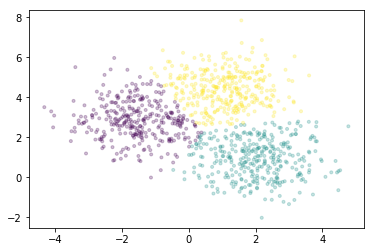

In [26]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

## Dask XGBOOST

In [11]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
X

dask.array<normal, shape=(100000, 20), dtype=float64, chunksize=(1000, 20)>

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:221: PerformanceWarning: Slicing with an out-of-order index is generating 842 times more chunks
  return X[indices]
/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:221: PerformanceWarning: Slicing with an out-of-order index is generating 149 times more chunks
  return X[indices]


In [20]:
import dask_xgboost
import xgboost

In [21]:
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 0.5}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

/home/jasonchandatascience/anaconda3/lib/python3.6/site-packages/distributed/worker.py:3101: UserWarning: Large object of size 1.04 MB detected in task graph: 
  [{'DMLC_NUM_WORKER': 4, 'DMLC_TRACKER_URI': '127.0 ... c50a104cf3e1']]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [22]:
bst

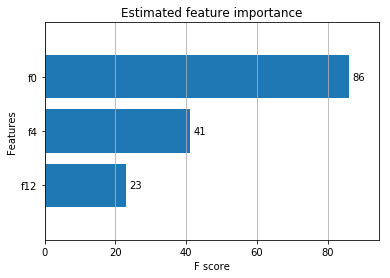

In [24]:
ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

## TPOT 

TPOT is an automated machine learning library. It evaluates many scikit-learn pipelines and hyperparameter combinations to find a model that works well for your data. Evaluating all these computations is computationally expensive, but ammenable to parallelism. TPOT can use Dask to distribute these computations on a cluster of machines.

In [4]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [5]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(
    digits.data,
    digits.target,
    train_size=0.05,
    test_size=0.95,
)

TPOT follows the scikit-learn API; we specify a TPOTClassifier with a few hyperparameters, and then fit it on some data. By default, TPOT trains on your single machine. To ensure your cluster is used, specify the use_dask keyword.



In [9]:
# use dask will already create a client for us
# use older version of scikit learn to have this working
tp = TPOTClassifier(
    generations=5,
    population_size=50,
    cv=10,
    n_jobs=-1,
    random_state=0,
    verbosity=2,
    use_dask=True
)

In [10]:
tp.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 0.9314285714285715
Generation 2 - Current best internal CV score: 0.9314285714285715
Generation 3 - Current best internal CV score: 0.9314285714285715
Generation 4 - Current best internal CV score: 0.9314285714285715
Generation 5 - Current best internal CV score: 0.9314285714285715

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=2, weights=uniform)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=10,
        disable_update_check=False, early_stop=None, generations=5,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=50,
        random_state=0, scoring=None, subsample=1.0, template='RandomTree',
        use_dask=True, verbosity=2, warm_start=False)

In [11]:
tp.score(X_test, y_test)

0.8758782201405152

In [15]:
tp.scoring_function

'accuracy'